In [1]:
import metmhn.regularized_optimization as reg_opt
import metmhn.Utilityfunctions as utils

import pandas as pd
import warnings
warnings.simplefilter(action='ignore', 
                      category=pd.errors.PerformanceWarning)

import jax.numpy as jnp
import numpy as np
import jax as jax
jax.config.update("jax_enable_x64", True)

import logging
# Adapt path to where logs should be kept
logging.basicConfig(filename='../logs/paad.log',
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w', 
                    level=logging.INFO, 
                    force=True,
                    datefmt='%Y-%m-%d %H:%M:%S'
                    )

In the following example, we have information about the genotypes of Primary Tumors (PTs) and Metastases (MTs) for patients suffering from Pancreatic adenocarcinomas (PAADs) and Pancreatic neuroendocrine tumors (PANETs). For some patients we only know the status of either the PT or the MT. This is indicated in our data in the column 'isPaired'. The column 'metaStatus' indicates the type of the tumor ('present', 'isMetastasis', 'absent') if only a single genotype is available.

In [2]:
mut_handle = "../data/paad/G13_PAADPANET_PM_v2_Events_30and15_Full.csv"
annot_handle = "../data/paad/G13_PAADPANET_PM_v2_sampleSelection_30and15.csv"
annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], 
               on=["patientID", "patientID"])
muts = ['P.KRAS (M)', 'M.KRAS (M)', 'P.TP53 (M)', 'M.TP53 (M)',
       'P.SMAD4/18q (Del)', 'M.SMAD4/18q (Del)', 'P.MYC/8q (Amp)', 'M.MYC/8q (Amp)',
       'P.TP53/17p (Del)', 'M.TP53/17p (Del)', 'P.SMAD4 (M)', 'M.SMAD4 (M)', 
       'P.KRAS/12p (Amp)', 'M.KRAS/12p (Amp)', 'P.SETD2/3p (Del)', 'M.SETD2/3p (Del)',
       'P.MEN1/11q (Del)', 'M.MEN1/11q (Del)',
       'P.RNF43 (M)', 'M.RNF43 (M)', 'P.MEN1 (M)', 'M.MEN1 (M)', 
       'P.GNAS (M)', 'M.GNAS (M)', 'P.DAXX (M)', 'M.DAXX (M)', 'P.KMT2C (M)',
       'M.KMT2C (M)', 'P.ATM (M)', 'M.ATM (M)', 'P.RBM10 (M)', 'M.RBM10 (M)',
       'P.BRCA2 (M)', 'M.BRCA2 (M)', 'P.ATRX (M)', 'M.ATRX (M)',
       'P.PIK3CA (M)', 'M.PIK3CA (M)', 'P.SETD2 (M)', 'M.SETD2 (M)',
       'P.TGFBR1 (M)', 'M.TGFBR1 (M)', 'P.RB1 (M)', 'M.RB1 (M)',
       'P.SMARCA4 (M)', 'M.SMARCA4 (M)', 'P.SMAD3 (M)', 'M.SMAD3 (M)',
       'P.MAP2K4 (M)', 'M.MAP2K4 (M)', 'P.TSC2 (M)', 'M.TSC2 (M)',
       'P.BCOR (M)', 'M.BCOR (M)', 'P.STK11 (M)', 'M.STK11 (M)', 'P.U2AF1 (M)',
       'M.U2AF1 (M)', 'P.SF3B1 (M)', 'M.SF3B1 (M)', 'P.PTPRT (M)',
       'M.PTPRT (M)']
#muts = list(dat.columns[1:-4])
muts

['P.KRAS (M)',
 'M.KRAS (M)',
 'P.TP53 (M)',
 'M.TP53 (M)',
 'P.SMAD4/18q (Del)',
 'M.SMAD4/18q (Del)',
 'P.MYC/8q (Amp)',
 'M.MYC/8q (Amp)',
 'P.TP53/17p (Del)',
 'M.TP53/17p (Del)',
 'P.SMAD4 (M)',
 'M.SMAD4 (M)',
 'P.KRAS/12p (Amp)',
 'M.KRAS/12p (Amp)',
 'P.SETD2/3p (Del)',
 'M.SETD2/3p (Del)',
 'P.MEN1/11q (Del)',
 'M.MEN1/11q (Del)',
 'P.RNF43 (M)',
 'M.RNF43 (M)',
 'P.MEN1 (M)',
 'M.MEN1 (M)',
 'P.GNAS (M)',
 'M.GNAS (M)',
 'P.DAXX (M)',
 'M.DAXX (M)',
 'P.KMT2C (M)',
 'M.KMT2C (M)',
 'P.ATM (M)',
 'M.ATM (M)',
 'P.RBM10 (M)',
 'M.RBM10 (M)',
 'P.BRCA2 (M)',
 'M.BRCA2 (M)',
 'P.ATRX (M)',
 'M.ATRX (M)',
 'P.PIK3CA (M)',
 'M.PIK3CA (M)',
 'P.SETD2 (M)',
 'M.SETD2 (M)',
 'P.TGFBR1 (M)',
 'M.TGFBR1 (M)',
 'P.RB1 (M)',
 'M.RB1 (M)',
 'P.SMARCA4 (M)',
 'M.SMARCA4 (M)',
 'P.SMAD3 (M)',
 'M.SMAD3 (M)',
 'P.MAP2K4 (M)',
 'M.MAP2K4 (M)',
 'P.TSC2 (M)',
 'M.TSC2 (M)',
 'P.BCOR (M)',
 'M.BCOR (M)',
 'P.STK11 (M)',
 'M.STK11 (M)',
 'P.U2AF1 (M)',
 'M.U2AF1 (M)',
 'P.SF3B1 (M)',
 'M.SF3B1 (M

In [3]:
# Label each datapoint with a numeric value according to its sequencetype
dat["type"] = dat.apply(utils.categorize, axis=1)
dat["Seeding"] = dat.apply(utils.add_seeding, axis=1)
dat.loc[dat["M.AgeAtSeqRep"] == "No metastasis included", "M.AgeAtSeqRep"] = pd.NA
dat.loc[dat["P.AgeAtSeqRep"] == "No primary included", "P.AgeAtSeqRep"] = pd.NA
dat["P.AgeAtSeqRep"] = dat["P.AgeAtSeqRep"].astype(pd.Int64Dtype())
dat["M.AgeAtSeqRep"] = dat["M.AgeAtSeqRep"].astype(pd.Int64Dtype())
dat["diag_order"] = dat["M.AgeAtSeqRep"] - dat["P.AgeAtSeqRep"]
dat["diag_order"] = dat["diag_order"].apply(lambda x: pd.NA if pd.isna(x) else 2 if x < 0 else 1 if x > 0 else 0) 
dat["diag_order"] = dat["diag_order"].astype(pd.Int64Dtype())
events_data = muts+["Seeding"]
# Only use datapoints where the state of the metastasis is known
cleaned = dat.loc[dat["type"].isin([0,1,2,3]), muts+["Seeding", "type", "diag_order"]]
cleaned.drop(cleaned[cleaned.iloc[:,:-2].sum(axis=1)<1].index, inplace=True)
dat_prim_nomet, dat_prim_met, dat_met_only, dat_coupled = utils.split_data(cleaned, events_data+["diag_order"])
import matplotlib.pyplot as plt
np.max(dat_coupled[:,:-1].sum(axis=1))

Array(19, dtype=int64)

Retrieve the event names and trim the PT/MT identifier:

In [4]:
events_plot = []
for elem in cleaned.columns[:-3].to_list()[::2]:
    full_mut_id = elem.split(".")
    events_plot.append(full_mut_id[1])
events_plot.append("Seeding")

Enumerate the frequencies of SNVs and CNVs in all subgroups. 'NM/EM' refer to Never Metastasizing/ Ever Metastasizing tumors, where only a single genotype is known. A Mutation is referred to as 'MT/PT-private' if happens exclusively in the MT or PT, otherwise it is called 'shared':

In [5]:
n_tot = (cleaned.shape[1]-1)//2 + 1
n_mut = n_tot-1
utils.marg_frequs(dat_prim_nomet[:,:-1], dat_prim_met[:,:-1], dat_met_only[:,:-1], dat_coupled[:,:-1], events_plot)

Coupled (81)                   NM (120) EM-PT (1011)  \
                  PT-Private MT-Private Shared  Present      Present   
KRAS (M)                0.05       0.04   0.69     0.79         0.86   
TP53 (M)                0.06       0.12   0.52     0.57         0.69   
SMAD4/18q (Del)         0.14       0.19   0.07     0.32         0.27   
MYC/8q (Amp)            0.05       0.10   0.07     0.22         0.17   
TP53/17p (Del)          0.09       0.17   0.04     0.21         0.17   
SMAD4 (M)               0.04       0.04   0.21     0.21         0.19   
KRAS/12p (Amp)          0.05       0.09   0.14     0.10         0.11   
SETD2/3p (Del)          0.04       0.11   0.06     0.12         0.10   
MEN1/11q (Del)          0.02       0.06   0.02     0.12         0.06   
RNF43 (M)               0.01       0.00   0.07     0.06         0.05   
MEN1 (M)                0.00       0.00   0.10     0.08         0.04   
GNAS (M)                0.00       0.01   0.01     0.05         0.04   
DAXX (M)                0.00       0.04   0.10     0.01         0.02   
KMT2C (M)               0.00       0.02   0.04     0.02         0.03   
ATM (M)                 0.00       0.01   0.04     0.01         0.02   
RBM10 (M)               0.00       0.00   0.00     0.02         0.03   
BRCA2 (M)               0.01       0.02   0.02     0.00         0.02   
ATRX (M)                0.01       0.02   0.04     0.03         0.02   
PIK3CA (M)              0.00       0.00   0.00     0.02         0.02   
SETD2 (M)               0.01       0.04   0.02     0.03         0.02   
TGFBR1 (M)              0.02       0.00   0.00     0.02         0.02   
RB1 (M)                 0.00       0.00   0.01     0.02         0.02   
SMARCA4 (M)             0.04       0.01   0.00     0.00         0.01   
SMAD3 (M)               0.00       0.04   0.00     0.01         0.02   
MAP2K4 (M)              0.00       0.00   0.01     0.02         0.01   
TSC2 (M)                0.00       0.06   0.01     0.01         0.01   
BCOR (M)                0.00       0.00   0.00     0.01         0.01   
STK11 (M)               0.00       0.00   0.01     0.01         0.01   
U2AF1 (M)               0.01       0.01   0.00     0.01         0.01   
SF3B1 (M)               0.00       0.00   0.02     0.01         0.01   
PTPRT (M)               0.00       0.02   0.01     0.03         0.01   
Seeding                 1.00       0.00   0.00     0.00         1.00   

                EM-MT (1122)  
                     Present  
KRAS (M)                0.82  
TP53 (M)                0.69  
SMAD4/18q (Del)         0.40  
MYC/8q (Amp)            0.33  
TP53/17p (Del)          0.31  
SMAD4 (M)               0.18  
KRAS/12p (Amp)          0.27  
SETD2/3p (Del)          0.23  
MEN1/11q (Del)          0.07  
RNF43 (M)               0.05  
MEN1 (M)                0.04  
GNAS (M)                0.02  
DAXX (M)                0.03  
KMT2C (M)               0.02  
ATM (M)                 0.03  
RBM10 (M)               0.02  
BRCA2 (M)               0.03  
ATRX (M)                0.02  
PIK3CA (M)              0.03  
SETD2 (M)               0.02  
TGFBR1 (M)              0.02  
RB1 (M)                 0.02  
SMARCA4 (M)             0.02  
SMAD3 (M)               0.01  
MAP2K4 (M)              0.02  
TSC2 (M)                0.02  
BCOR (M)                0.02  
STK11 (M)               0.02  
U2AF1 (M)               0.02  
SF3B1 (M)               0.01  
PTPRT (M)               0.01  
Seeding                 1.00

Optional: We use a  sparsity promoting L1 penalty. The weight of the penalization can be determined in a k-fold crossvalidation:

In [6]:
#log_lams = np.linspace(-4, -2, 5)
#lams = 10**log_lams
#print(lams)
#utils.cross_val(cleaned.copy(), events_data, lams, 5, 0.83)

Train an MHN on the full dataset:

In [8]:
penal = 0.002 #L1 penalty on off-diagonals
m_p_corr = 0.83
th_init, dp_init, dm_init = utils.indep(jnp.array(cleaned[events_data].to_numpy()), dat_coupled.shape[0])
theta, d_p, d_m= reg_opt.learn_mhn(th_init, dp_init, dm_init, dat_prim_nomet, dat_prim_met, dat_met_only,
                                    dat_coupled, m_p_corr, penal)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1088     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10821D+04    |proj g|=  1.33043D+03


 This problem is unconstrained.



At iterate    1    f=  1.95818D+04    |proj g|=  6.37045D+02

At iterate    2    f=  1.91462D+04    |proj g|=  5.26035D+02

At iterate    3    f=  1.89349D+04    |proj g|=  1.88148D+02

At iterate    4    f=  1.86028D+04    |proj g|=  2.27288D+02

At iterate    5    f=  1.82800D+04    |proj g|=  3.29851D+02

At iterate    6    f=  1.80912D+04    |proj g|=  2.27749D+02

At iterate    7    f=  1.79098D+04    |proj g|=  9.96013D+01

At iterate    8    f=  1.78609D+04    |proj g|=  4.28578D+01

At iterate    9    f=  1.77818D+04    |proj g|=  1.34605D+02

At iterate   10    f=  1.77157D+04    |proj g|=  1.33306D+02

At iterate   11    f=  1.76505D+04    |proj g|=  9.22869D+01

At iterate   12    f=  1.76069D+04    |proj g|=  1.44762D+02

At iterate   13    f=  1.75634D+04    |proj g|=  4.19435D+01

At iterate   14    f=  1.75333D+04    |proj g|=  2.64334D+01

At iterate   15    f=  1.75047D+04    |proj g|=  5.83560D+01

At iterate   16    f=  1.74799D+04    |proj g|=  4.70256D+01

At iter

In [9]:
th_plot = np.row_stack((d_p.reshape((1,-1)), 
                        d_m.reshape((1,-1)), 
                        theta))

Visualize the results:

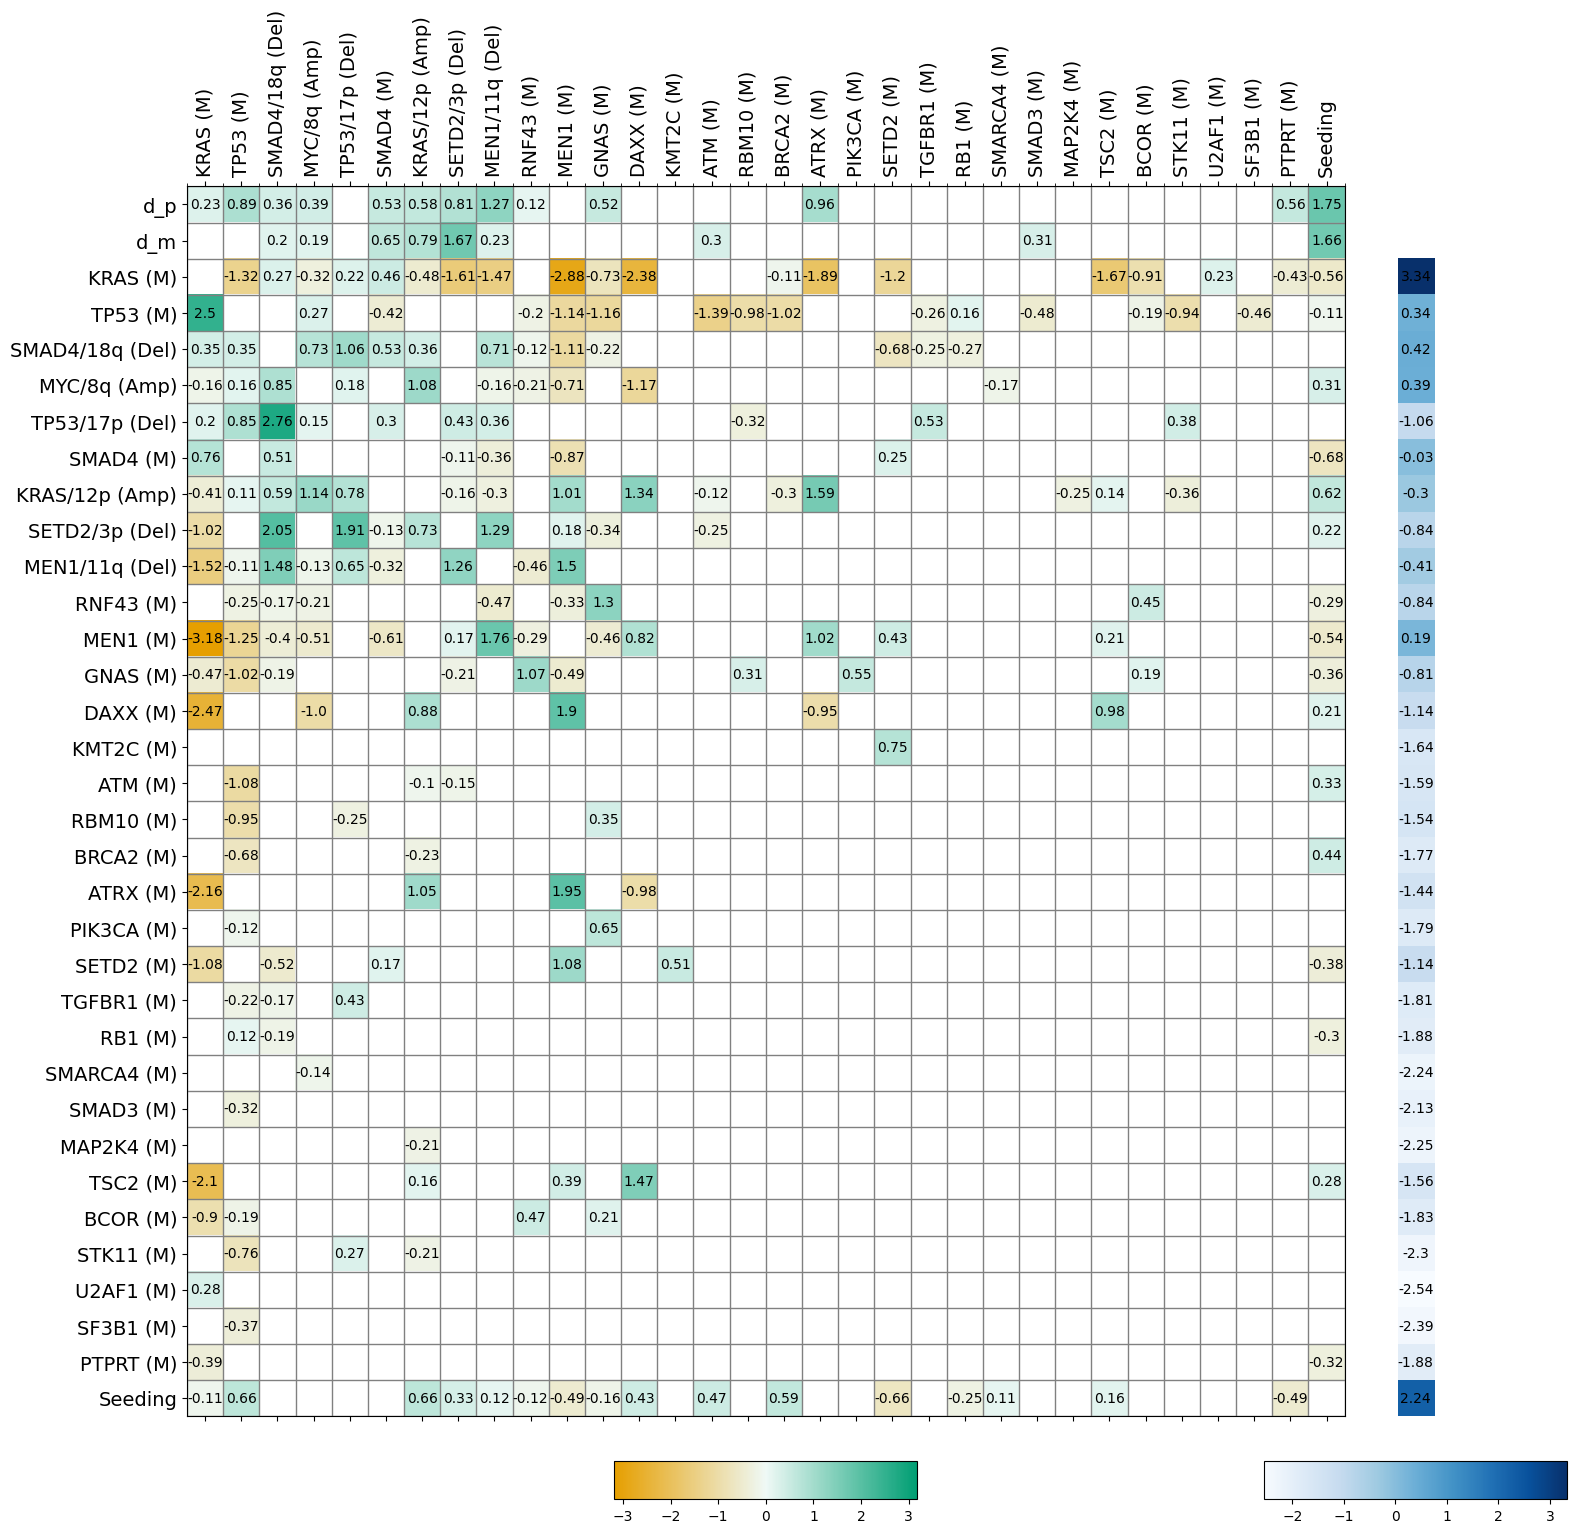

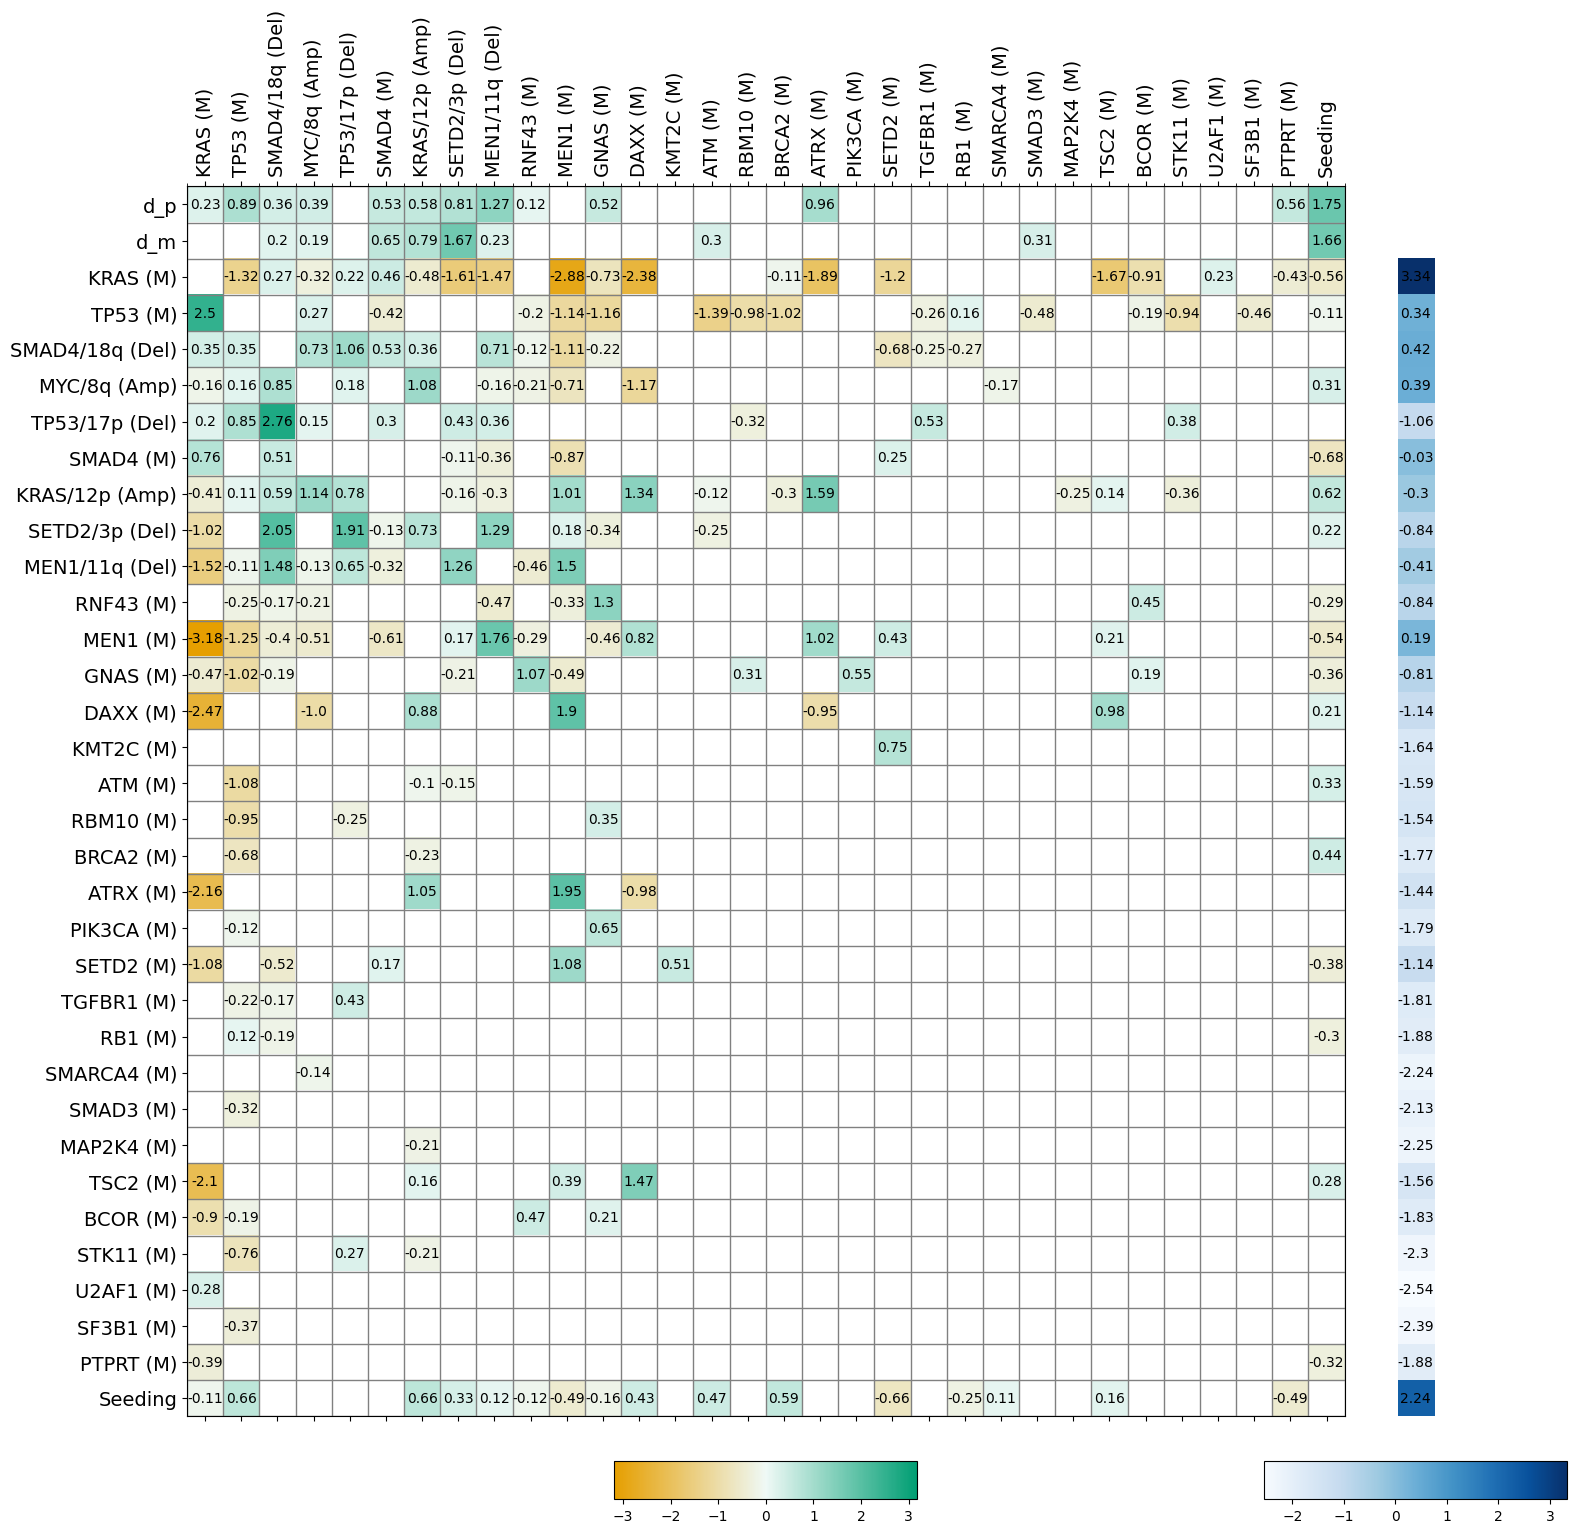

In [10]:
utils.plot_theta(th_plot, events_plot, .1)

In [ ]:
df2 = pd.DataFrame(th_plot, columns=events_plot)
df2.to_csv("../results/paad/paad_cd_25_muts_6_cnvs_0009.csv")
